In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from scipy.stats import uniform, randint
import time
import joblib

In [ ]:
warnings.filterwarnings('ignore')
train_data = pd.read_csv('/content/drive/MyDrive/Train AI 2/train_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Train AI 2/test_data.csv')

In [ ]:
scaler = StandardScaler()
# Select numeric columns (for standardization)
numeric_columns = train_data.select_dtypes(include=['float64', 'int64']).columns

# Drop unwanted columns from the numeric columns
numeric_columns = numeric_columns.difference(['timestamp', 'col', 'row', 'aws-12', 'binary_label'])

# Fit and transform the training data
train_data[numeric_columns] = scaler.fit_transform(train_data[numeric_columns])

# Transform the test data using the same scaler (to avoid data leakage)
test_data[numeric_columns] = scaler.transform(test_data[numeric_columns])

# # Check the result
# print("Standardized train data:\n", train_data.head())
# print("Standardized test data:\n", test_data.head())

In [ ]:
X_train = train_data.drop(columns=['timestamp', 'col', 'row', 'aws', 'aws-12', 'binary_label'])
y_train = train_data['aws']
X_test = test_data.drop(columns=['timestamp', 'col', 'row', 'aws', 'aws-12', 'binary_label'])
y_test = test_data['aws']

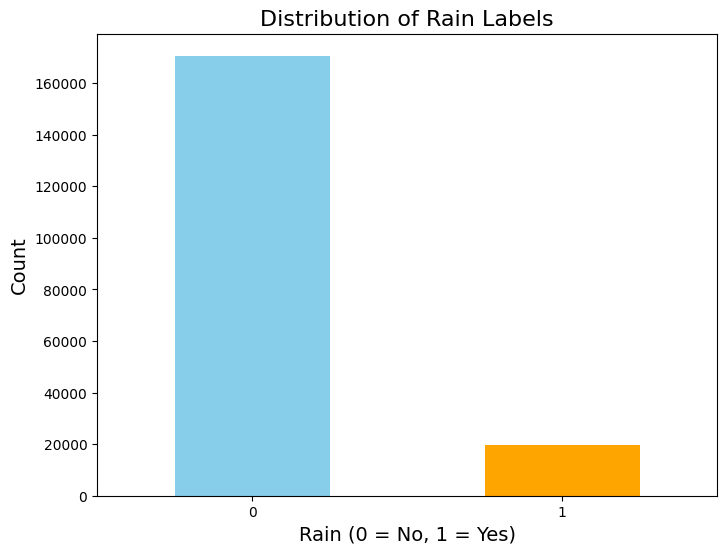

In [ ]:
# view data distribution
plt.figure(figsize=(8, 6))
train_data['binary_label'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Distribution of Rain Labels', fontsize=16)
plt.xlabel('Rain (0 = No, 1 = Yes)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.show()

In [ ]:
def objective(params):
    # Instantiate XGBRegressor with current parameters
    model = xgb.XGBRFRegressor(
        max_depth=int(params['max_depth']),
        n_estimators=int(params['n_estimators']),
        subsample=params['subsample'],
        min_child_weight=params['min_child_weight'],
        colsample_bytree=params['colsample_bytree'],
        random_state=42
    )

    # Perform cross-validation
    # many optimization algorithms, including cross_val_score, are designed to maximize scores rather than minimize errors
    score = -cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()
    return {'loss': score, 'status': STATUS_OK}

# Define the search space
# uniform: every value within the interval has an equal probability of being selected.
space = {
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 500, 50),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
}

trials = Trials()

# Run optimization
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  # Number of evaluations for Hyperopt to run
    trials=trials,
    rstate=np.random.default_rng(42)
)

# Print best parameters found
print("Best Parameters:", best)

100%|██████████| 50/50 [1:08:38<00:00, 82.38s/trial, best loss: 0.511683203016179] 
Best Parameters: {'colsample_bytree': 0.6385983390827173, 'max_depth': 15.0, 'min_child_weight': 3.0, 'n_estimators': 350.0, 'subsample': 0.778209676459918}


In [ ]:
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

# Hyperopt may return some values in float even for integer parameters
best_model = xgb.XGBRFRegressor(
    n_estimators=best['n_estimators'],
    max_depth=best['max_depth'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    min_child_weight=best['min_child_weight'],
    random_state=42
)

In [ ]:
best_model.fit(X_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=0.6385983390827173,
               device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=15, max_leaves=None,
               min_child_weight=3, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=350, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=42, reg_alpha=None, ...)

In [ ]:
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 0.48087347860305796
Mean Absolute Error: 0.14579338941293432
R-squared: 0.5151517367181403


In [ ]:
aws_index = numeric_columns.get_loc('aws')

target_mean = scaler.mean_[aws_index]
target_scale = scaler.scale_[aws_index]

# Destandardize y_test and y_pred
y_test_original = y_test * target_scale + target_mean
y_pred_original = y_pred * target_scale + target_mean

# Recalculate metrics on destandardized data
mse_original = mean_squared_error(y_test_original, y_pred_original)
mae_original = mean_absolute_error(y_test_original, y_pred_original)
r2_original = r2_score(y_test_original, y_pred_original)

# Print results
print("Metrics on Original Data Scale:")
print("Mean Squared Error:", mse_original)
print("Mean Absolute Error:", mae_original)
print("R-squared:", r2_original)

Metrics on Original Data Scale:
Mean Squared Error: 2.8960039831583986
Mean Absolute Error: 0.35778489154856413
R-squared: 0.5151517398675249


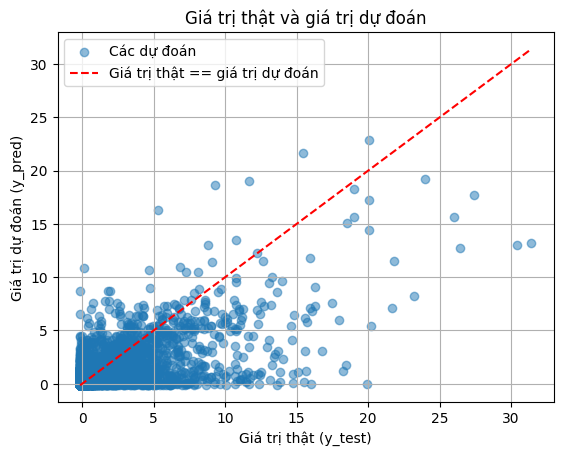

In [ ]:
#ploting model performance
# Scatter plot
plt.scatter(y_test, y_pred, alpha=0.5, label="Các dự đoán")

# Add diagonal line
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Giá trị thật == giá trị dự đoán")

# Add labels, grid, and legend
plt.title("Giá trị thật và giá trị dự đoán")
plt.xlabel("Giá trị thật (y_test)")
plt.ylabel("Giá trị dự đoán (y_pred)")
plt.grid()
plt.legend()
plt.show()

# plt.savefig('/content/drive/My Drive/Train AI 2/example_plot.png')
# plt.close()

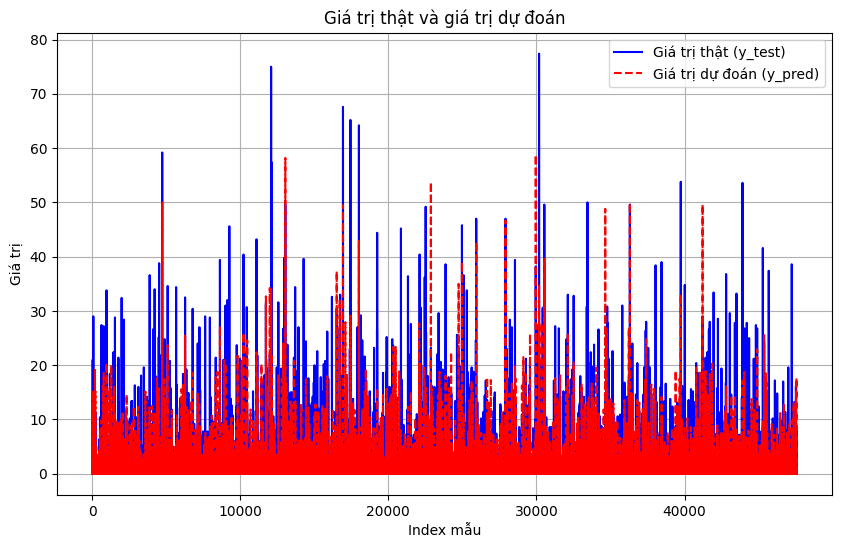

In [ ]:
# Generate an index for the samples
samples = np.arange(len(y_test))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the true values (y_test)
plt.plot(samples, y_test, color='blue', label='Giá trị thật (y_test)', linestyle='-')

# Plot the predicted values (y_pred)
plt.plot(samples, y_pred, color='red', label='Giá trị dự đoán (y_pred)', linestyle='--')

# Add labels, title, grid, and legend
plt.title('Giá trị thật và giá trị dự đoán')
plt.xlabel('Index mẫu')
plt.ylabel('Giá trị')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [ ]:
joblib.dump(best_model, '/content/drive/My Drive/Train AI 2/randomforest_model_2.joblib')
# best_model = joblib.load('/content/drive/My Drive/Train AI 2/xgboost_model.joblib') # if have trained a model

['/content/drive/My Drive/Train AI 2/randomforest_model_2.joblib']

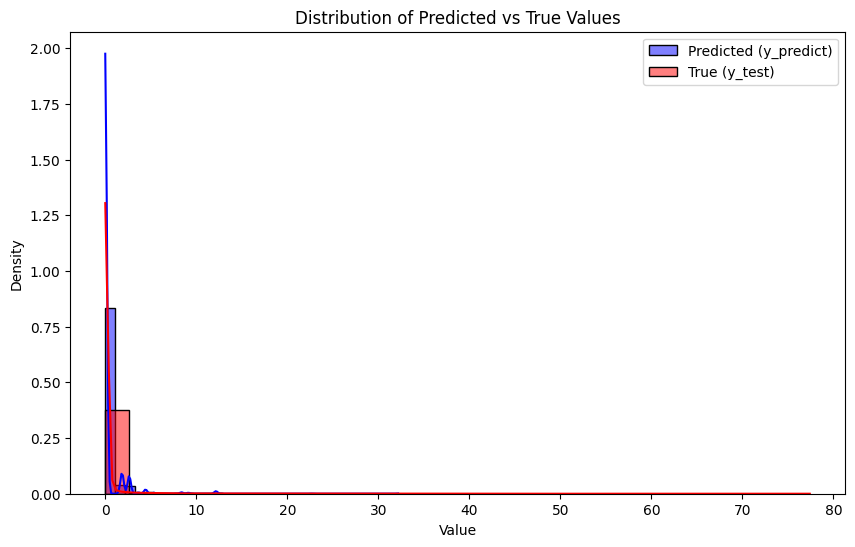

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot histogram for y_predict
sns.histplot(y_pred, color='blue', kde=True, stat="density", label='Predicted (y_predict)', bins=30)

# Plot histogram for y_test
sns.histplot(y_test, color='red', kde=True, stat="density", label='True (y_test)', bins=30)

# Add titles and labels
plt.title('Distribution of Predicted vs True Values')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()